In [1]:
%%capture
%run 02_FeatEng.ipynb

In [2]:
def wrap_adfuller(data, regression='c'):
    from statsmodels.tsa.stattools import adfuller
    adf_res_dict = {}
    for col in data.columns:
        adf_res = adfuller(data[col], regression =regression)
        adf_res_dict[col] = adf_res
        print(f'{col}: p-value: {adf_res[1]:0.2f}')
    return adf_res_dict

In [46]:
def wrap_kpss(data, regression='c', nlags='auto'):
    from statsmodels.tsa.stattools import kpss
    kpss_res_dict = {}
    for col in data.columns:
        kpss_res = kpss(data[col], regression =regression)
        kpss_res_dict[col] = kpss_res
        print(f'{col}: p-value: {kpss_res[1]:0.2f}')
    return kpss_res_dict

In [30]:
def plot_time_series_with_rolling(x: pd.Series, period: int, *args, **kwargs):
    figsize =  kwargs.get('figsize', (8, 4))
    title =  kwargs.get('title', x.name)
    ylabel = kwargs.get('ylabel', '')
    ax = x.plot(figsize=figsize, label=x.name, title=title)
    x.rolling(period).mean().plot(label=f'{period} mave', color='red', ax=ax)
    x.rolling(period).std().plot( label=f'{period} mstd', color='orange', ax=ax)
    ax.set_ylabel(ylabel)
    plt.legend()
    return ax

In [24]:

def plot_seas_model(model, *args, **kwargs):
    figsize = kwargs.get("figsize", (16,8))
    title = kwargs.get("title", "")
    ylabel = kwargs.get("ylabel", "")
    fig, axs = plt.subplots(3,1, sharex=True, figsize=(15,8))
    ax1,ax2,ax3 = axs
    plt.suptitle(f'{title} Time Series Decomposition')
    model.observed.plot(label='observed', legend=True, ax=ax1)
    model.trend.plot(label='trend', legend=True, ax=ax1)
    (model.observed- model.seasonal).plot(label='seas. adj.', legend=True, ax=ax1)
    model.seasonal.plot(label='seasonal', legend=True, ax=ax2)
    (model.observed-model.trend).plot(legend=True, label='detrended', ax=ax2)
    model.resid.plot(legend=True, label='resids', ax=ax3)
    
    ax1.set_ylabel(ylabel)
    ax2.set_ylabel(ylabel)
    ax3.set_ylabel(ylabel)
    return fig, axs



# Seasonality Analysis

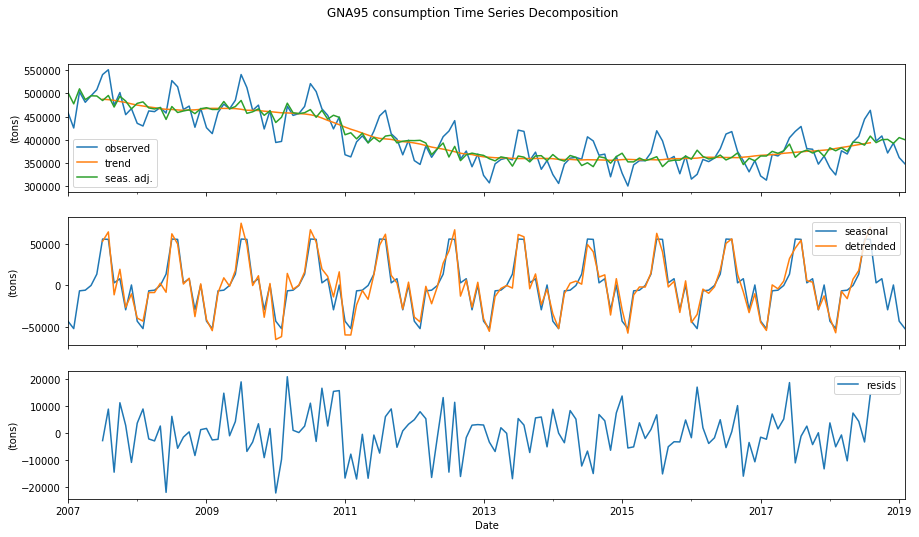

In [25]:
fig, axs = plot_seas_model(seas_models['cons_GNA95'], title='GNA95 consumption', ylabel='(tons)')
plt.show()

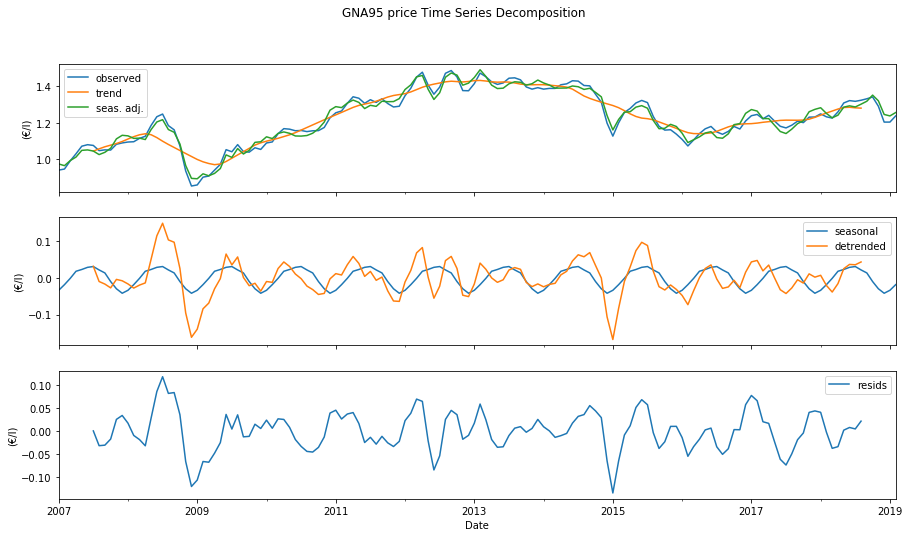

In [26]:
fig, axs = plot_seas_model(seas_models['price_GNA95'], title='GNA95 price', ylabel='(€/l)')
plt.show()

# Stationarity Checking

In [36]:
adf_test_cols = ['cons_GNA95', 'cons_GNA95_pct_change1', 'cons_GNA95_seas_adj', 'cons_GNA95_seas_adj_pct_change1', 'cons_GNA95_seas_adj_diff1',
                 'cons_GNA95_diff1', 'cons_GNA95_diff1_sdiff12',
                'price_GNA95', 'price_GNA95_pct_change1', 'price_GNA95_seas_adj', 'price_GNA95_seas_adj_pct_change1', 'price_GNA95_seas_adj_diff1',
                'price_GNA95_diff1', 'price_GNA95_diff1_sdiff12',]
_ = wrap_adfuller(data[adf_test_cols], regression='c')

cons_GNA95: p-value: 0.28
cons_GNA95_pct_change1: p-value: 0.47
cons_GNA95_seas_adj: p-value: 0.31
cons_GNA95_seas_adj_pct_change1: p-value: 0.56
cons_GNA95_seas_adj_diff1: p-value: 0.51
cons_GNA95_diff1: p-value: 0.51
cons_GNA95_diff1_sdiff12: p-value: 0.00
price_GNA95: p-value: 0.36
price_GNA95_pct_change1: p-value: 0.00
price_GNA95_seas_adj: p-value: 0.48
price_GNA95_seas_adj_pct_change1: p-value: 0.00
price_GNA95_seas_adj_diff1: p-value: 0.00
price_GNA95_diff1: p-value: 0.00
price_GNA95_diff1_sdiff12: p-value: 0.00


In [41]:
_ = wrap_adfuller(data[['cons_GNA95_seas_adj_pct_change1']], regression='ct')

cons_GNA95_seas_adj_pct_change1: p-value: 0.14


In [47]:
_ = wrap_kpss(data[['cons_GNA95_seas_adj_pct_change1']], regression='c', nlags='auto')

cons_GNA95_seas_adj_pct_change1: p-value: 0.02


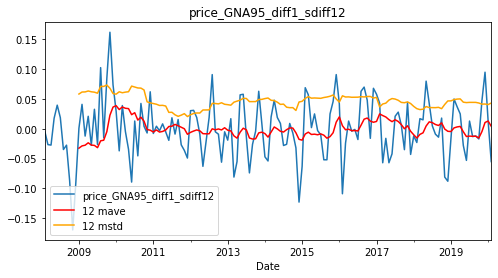

In [31]:
ax = plot_time_series_with_rolling(x=data['price_GNA95_diff1_sdiff12'], period=12)

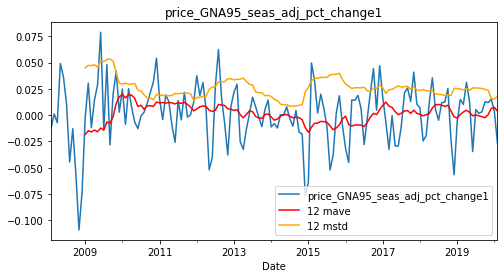

In [32]:
ax = plot_time_series_with_rolling(x=data['price_GNA95_seas_adj_pct_change1'], period=12)

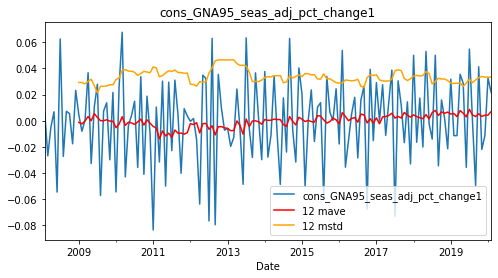

In [33]:
ax = plot_time_series_with_rolling(x=data['cons_GNA95_seas_adj_pct_change1'], period=12)

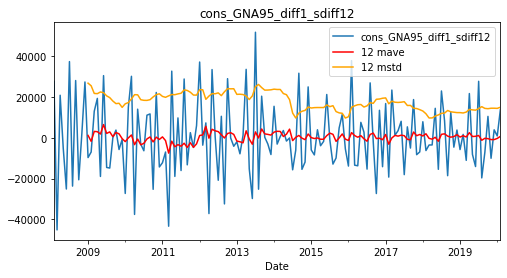

In [34]:
ax = plot_time_series_with_rolling(x=data['cons_GNA95_diff1_sdiff12'], period=12)

# Autocorrelation

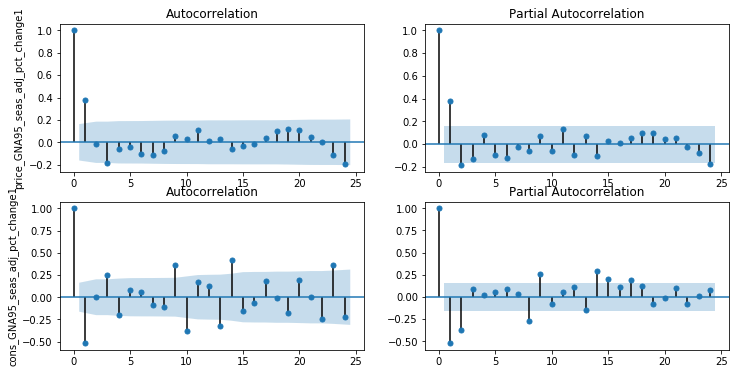

In [48]:
fig, axs   = plt.subplots(2, 2, figsize=(12,6))

for idx_row, col in enumerate(['price_GNA95_seas_adj_pct_change1', 'cons_GNA95_seas_adj_pct_change1']):
    plot_acf(data[col], lags=24, ax=axs[idx_row,0])
    plot_pacf(data[col],lags=24, ax=axs[idx_row,1])
    axs[idx_row,0].set_ylabel(col)

In [49]:
def pairwise_corr_over_time(data, x: str, ys: list, nlags):
    data_cp = data[[x] + ys].copy()
    x_lags = []
    for tau in range(nlags):
        data_cp[f'{x}_lag{tau}'] = data_cp[x].shift(tau)
        x_lags.append(f'{x}_lag{tau}')
    data_cp = data_cp[nlags:].copy()
    corr = data_cp.corr().loc[x_lags, ys]
    return corr


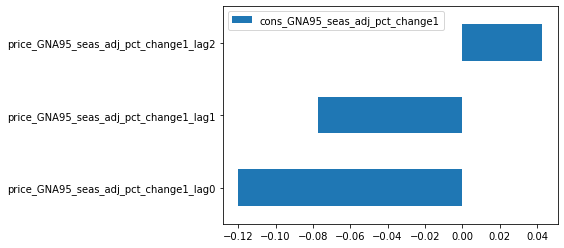

In [54]:
gna_corr = pairwise_corr_over_time(data, 'price_GNA95_seas_adj_pct_change1', ['cons_GNA95_seas_adj_pct_change1'], 3)
gna_corr.plot.barh()
plt.show()

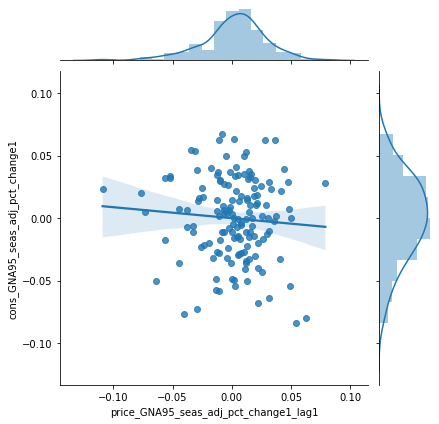

In [56]:
g = sns.jointplot('price_GNA95_seas_adj_pct_change1_lag1', 'cons_GNA95_seas_adj_pct_change1', data, kind='reg')
plt.show()

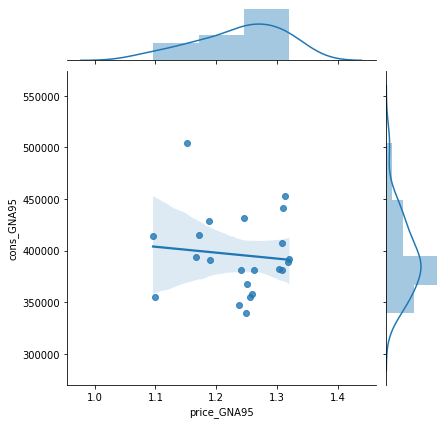

In [55]:
week_gna = data.groupby('week')[['price_GNA95', 'cons_GNA95']].median()
g = sns.jointplot('price_GNA95', 'cons_GNA95', week_gna, kind='reg')
plt.show()